In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 300
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:

workers = 2
batch_size = 16
image_size = 64
ngpu = 1

In [3]:
import torchvision.datasets as dset
#ImgLocation='/content/drive/MyDrive/Colab Notebooks/Subset_Dil_Bos/'
ImgLocation="C:/Users/elyon/OneDrive/Desktop/Tesi/dataset/"
dataset = dset.ImageFolder(root=ImgLocation,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)


In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
#device=torch.device('cpu')
print(device)

cuda:0


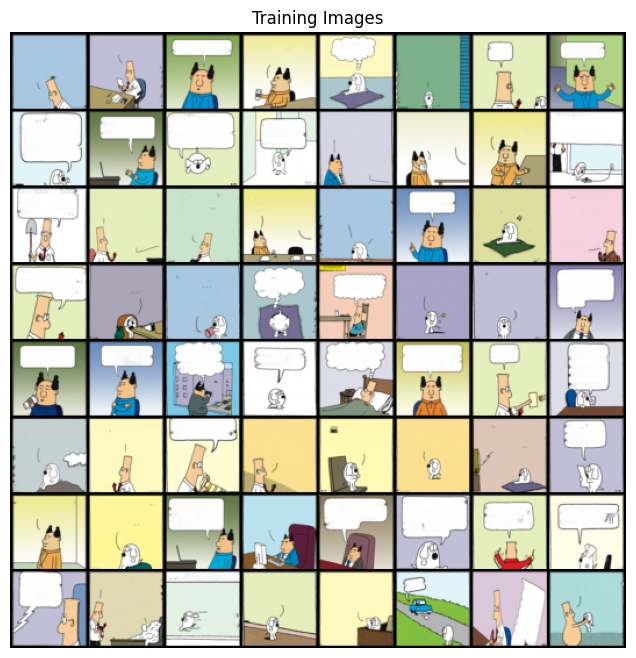

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
#plt.imshow(real_batch)

In [5]:

class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self,ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(3*image_size * image_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [7]:
'''
discriminator = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)

# Print the model
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=12288, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


Implementing the Generator
==========================


In [6]:
# Quantum variables
n_qubits = 13  # Total number of qubits / N
n_a_qubits = 2  # Number of ancillary qubits / N_A
q_depth = 2  # Depth of the parameterised quantum circuit / D
n_generators = 6  # Number of subgenerators for the patch method / N_G

Now we define the quantum device we want to use, along with any
available CUDA GPUs (if available).


In [7]:
# Quantum simulator
#dev = qml.device("default.qubit", wires=n_qubits)
dev = qml.device("lightning.qubit", wires=n_qubits)
print(dev)

Lightning Qubit PennyLane plugin
Short name: lightning.qubit
Package: pennylane_lightning
Plugin version: 0.33.0
Author: Xanadu Inc.
Wires: 13
Shots: None


In [8]:

@qml.qnode(dev, interface="torch") # diff_method="parameter-shift"
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [9]:

class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

Training
========


In [10]:

lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 100# Number of training iterations

In [11]:

discriminator = Discriminator(ngpu).to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

In [12]:
print(discriminator)


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=12288, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [13]:
print(generator)

PatchQuantumGenerator(
  (q_params): ParameterList(
      (0): Parameter containing: [torch.float32 of size 26 (cuda:0)]
      (1): Parameter containing: [torch.float32 of size 26 (cuda:0)]
      (2): Parameter containing: [torch.float32 of size 26 (cuda:0)]
      (3): Parameter containing: [torch.float32 of size 26 (cuda:0)]
      (4): Parameter containing: [torch.float32 of size 26 (cuda:0)]
      (5): Parameter containing: [torch.float32 of size 26 (cuda:0)]
  )
)


In [14]:

criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)



# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2


In [ ]:

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):


        # Data for training the discriminator
     
        data = data.reshape(-1, image_size * image_size*3)

        real_data = data.to(device)
        b_size = real_data.size(0)
        
        
        real_labels = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
        fake_labels = torch.full((b_size,), 0.0, dtype=torch.float, device=device)
       


        # Training the discriminator

        noise = torch.rand(b_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)
  
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)

        errD_real = criterion(outD_real, real_labels)
        
        # Noise following a uniform distribution in range [0,pi/2)
        outD_fake = discriminator(fake_data.detach()).view(-1)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()



        # Training the generator
        generator.zero_grad()
    
        outD_fake = discriminator(fake_data).view(-1)
     
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1
        

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(batch_size,3,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

            if counter == num_iter:
                  break
    if counter == num_iter:
          break

Iteration: 10, Discriminator Loss: 0.308, Generator Loss: 1.337
Iteration: 20, Discriminator Loss: 0.297, Generator Loss: 1.366
Iteration: 30, Discriminator Loss: 0.295, Generator Loss: 1.396


In [19]:
'''
# Iteration counter
counter = 0
G_losses = []
D_losses = []
# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):
        # Data for training the discriminator
        data = data.reshape( -1,image_size * image_size*3) #data=(32,12288)
        real_data = data.to(device) #real_data=(32,12288)
        b_size = real_data.size(0)
        real_labels = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
        fake_labels = torch.full((b_size,), 0.0, dtype=torch.float, device=device)
        
        # Training the discriminator
        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2 #noise=(32,13)
        fake_data = generator(noise)  #fake_data=(32,12288)

        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1) #(outD_real=32)

        errD_real = criterion(outD_real, real_labels)  #(criterion(32, 32))

        outD_fake = discriminator(fake_data.detach()).view(-1) #(outD_fake=32)

        errD_fake = criterion(outD_fake, fake_labels)  #(criterion(32,32))
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()

        outD_fake = discriminator(fake_data).view(-1)  #outD_fake=32

        errG = criterion(outD_fake, real_labels) #criterion(32,32)
        errG.backward()
        optG.step()

        counter += 1
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(batch_size,3,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 0.328, Generator Loss: 1.280


ValueError: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([16])) is deprecated. Please ensure they have the same size.

In [15]:
save_path="C:/Users/elyon/OneDrive/Desktop/Tesi/official tesi data/model_quantum.pt"

In [16]:
def save_checkpoint(gen,dis, optg,optd, save_path):
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'dis_state_dict': dis.state_dict(),
        'optG_state_dict': optg.state_dict(),
        'optD_state_dict': optd.state_dict()

    }, save_path)
def load_checkpoint(gen,dis, optg,optd, load_path):
    checkpoint = torch.load(load_path)
    gen.load_state_dict(checkpoint['gen_state_dict'])
    dis.load_state_dict(checkpoint['dis_state_dict'])
    optg.load_state_dict(checkpoint['optG_state_dict'])
    optd.load_state_dict(checkpoint['optD_state_dict'])


    return gen,dis, optg, optd

In [33]:
save_checkpoint(generator,discriminator, optG,optD, save_path)

In [17]:
load_checkpoint(generator,discriminator, optG,optD, save_path)

(PatchQuantumGenerator(
   (q_params): ParameterList(
       (0): Parameter containing: [torch.float32 of size 26 (cuda:0)]
       (1): Parameter containing: [torch.float32 of size 26 (cuda:0)]
       (2): Parameter containing: [torch.float32 of size 26 (cuda:0)]
       (3): Parameter containing: [torch.float32 of size 26 (cuda:0)]
       (4): Parameter containing: [torch.float32 of size 26 (cuda:0)]
       (5): Parameter containing: [torch.float32 of size 26 (cuda:0)]
   )
 ),
 Discriminator(
   (model): Sequential(
     (0): Linear(in_features=12288, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=16, bias=True)
     (5): ReLU()
     (6): Linear(in_features=16, out_features=1, bias=True)
     (7): Sigmoid()
   )
 ),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.3
     maximize: False
     momentum: 0
     neste

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [47]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results.T):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy())
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*100}', loc='left')
        fig.add_subplot(ax)

plt.show()

TypeError: Invalid shape (64,) for image data

<Figure size 1000x500 with 0 Axes>

C:\Users\elyon\AppData\Local\Temp\ipykernel_16720\2449652858.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(2,2), facecolor='white')


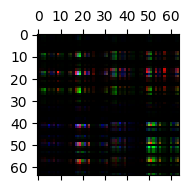

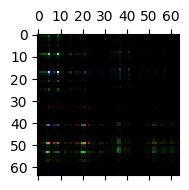

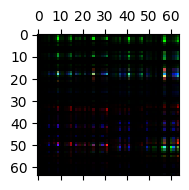

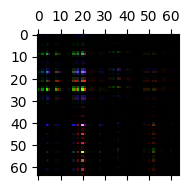

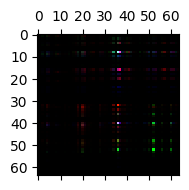

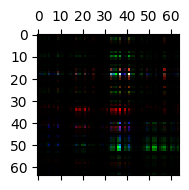

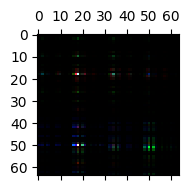

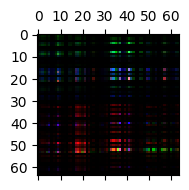

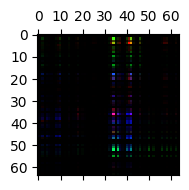

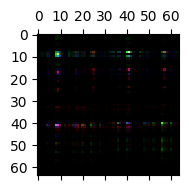

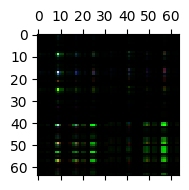

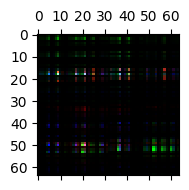

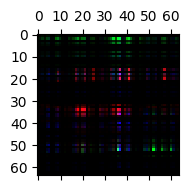

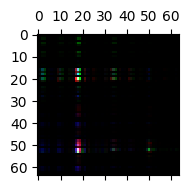

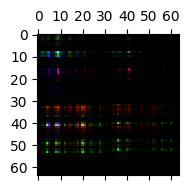

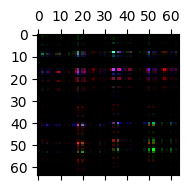

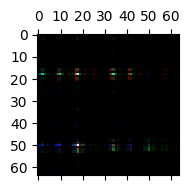

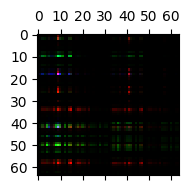

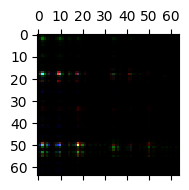

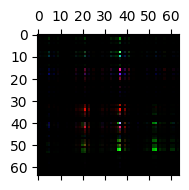

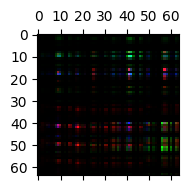

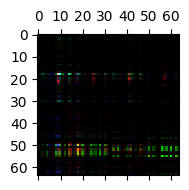

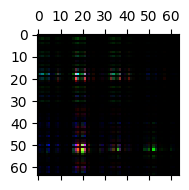

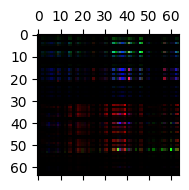

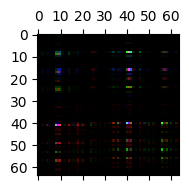

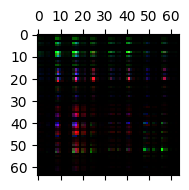

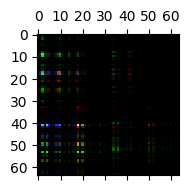

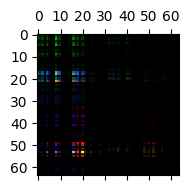

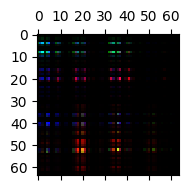

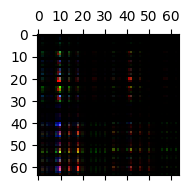

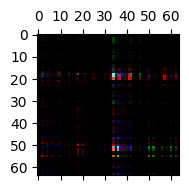

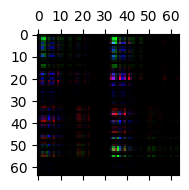

In [34]:

for k in range(len(test_images)) :
     
      fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(2,2), facecolor='white')


      axs.matshow(np.squeeze(test_images[k].permute(1,2,0)))

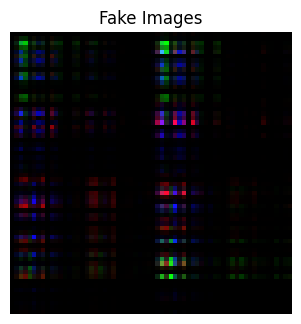

In [35]:
plt.figure(figsize=(8,8))
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(test_images[-1],(1,2,0)))
plt.show()